In [1]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load the results per survey

In [18]:
survey = 'PanStarrs'
# survey = 'Gaia'
# survey = 'ZTF'
results = glob('../04_ComputeMetrics/{}/Results/*'.format(survey))
results.sort()
results

['../04_ComputeMetrics/PanStarrs/Results/Fold_1_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_2_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_3_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_4_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_5_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_6_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_7_Results.dat']

Estimate the median of each prediction

In [19]:
# Read the first DataFrame to include data here
dfs = pd.read_csv(results[0])
# Get the column names
columns = dfs.columns
# Only extract the columns with physical parameters
params = ['_'.join(i.split('_')[1:]) for i in columns if 'Pred_' in i]
# Get the true and predicted values
def get_cols(df, params):
    """Extracts the pred and true physical parameters."""
    # Columns containing the relevant information
    cols = ['Pred_','True_']
    df = df[[p+i for i in params for p in cols]]
    return df
dfs = get_cols(dfs, params)
# only get the predictions
sel_params = ['Pred_'+param for param in params]
# Iterate over all the folds to create a single dataframe
for i,result in enumerate(results[1:], start=1):
    df = pd.read_csv(result)
    df = get_cols(df, params)
    dfs = pd.merge(dfs, df[sel_params], how='inner', left_index=True, right_index=True,suffixes=('','_'+str(i)))

# Compute the median and mean, per parameter
output_df = dfs[[i for i in dfs.columns if 'True_' in i]].copy()
for param in params:
    # Select only the predicted columns
    pred_cols_param = [col for col in dfs.columns if 'Pred_'+param in col]
    sel = dfs[pred_cols_param]
    # Get the statistics
    median = sel.median(axis=1)
    mean = sel.mean(axis=1)
    # Output the dataframe
    output_df = output_df.assign(**{'median_'+param:median ,
                                    'mean_'+param: mean})
output_df.head()

,True_T_eff,True_Radius,median_T_eff,mean_T_eff,median_Radius,mean_Radius
84300158481827892,7396.3037,-1.0,7285.7590,7350.774300,2.986656,4.742947
74163190788076994,5955.7760,-1.0,6164.4080,6142.597514,11.409092,10.317746
103253008374854869,6638.7150,-1.0,5754.9253,5752.894414,11.474436,8.144556
74022884304620926,7203.6280,-1.0,6691.5337,6681.255014,2.368339,4.867855
131542740608734400,6253.8680,-1.0,5885.1260,5833.205900,8.247026,5.544814


## For  T_eff

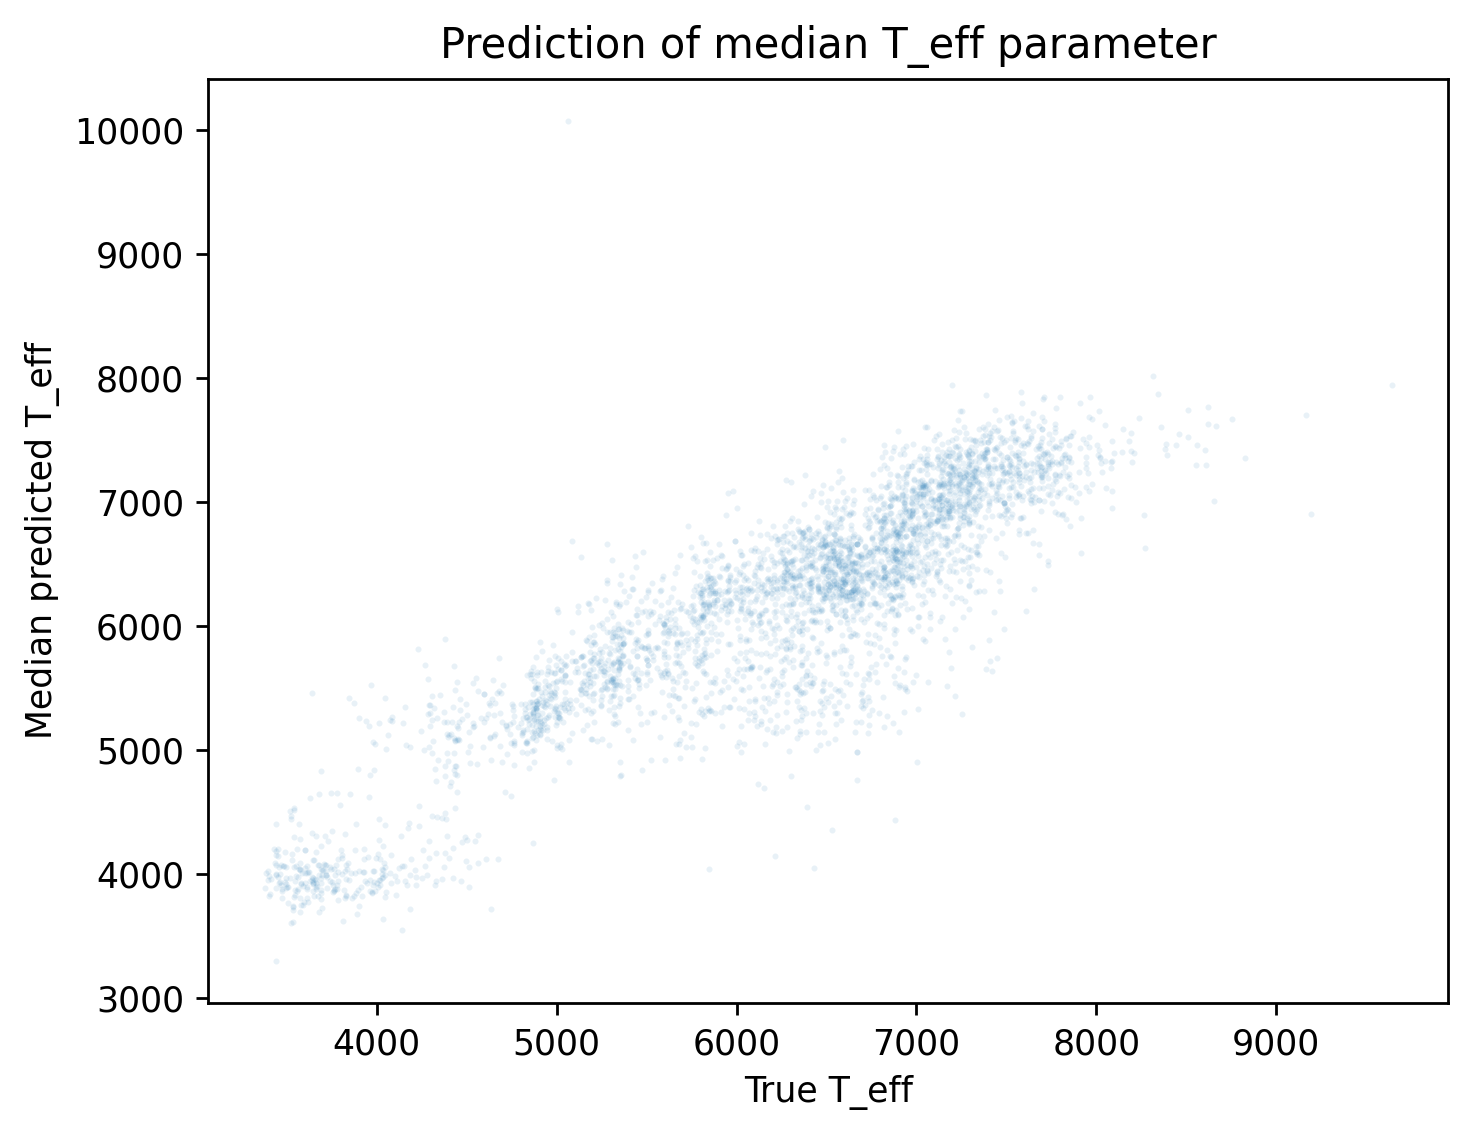

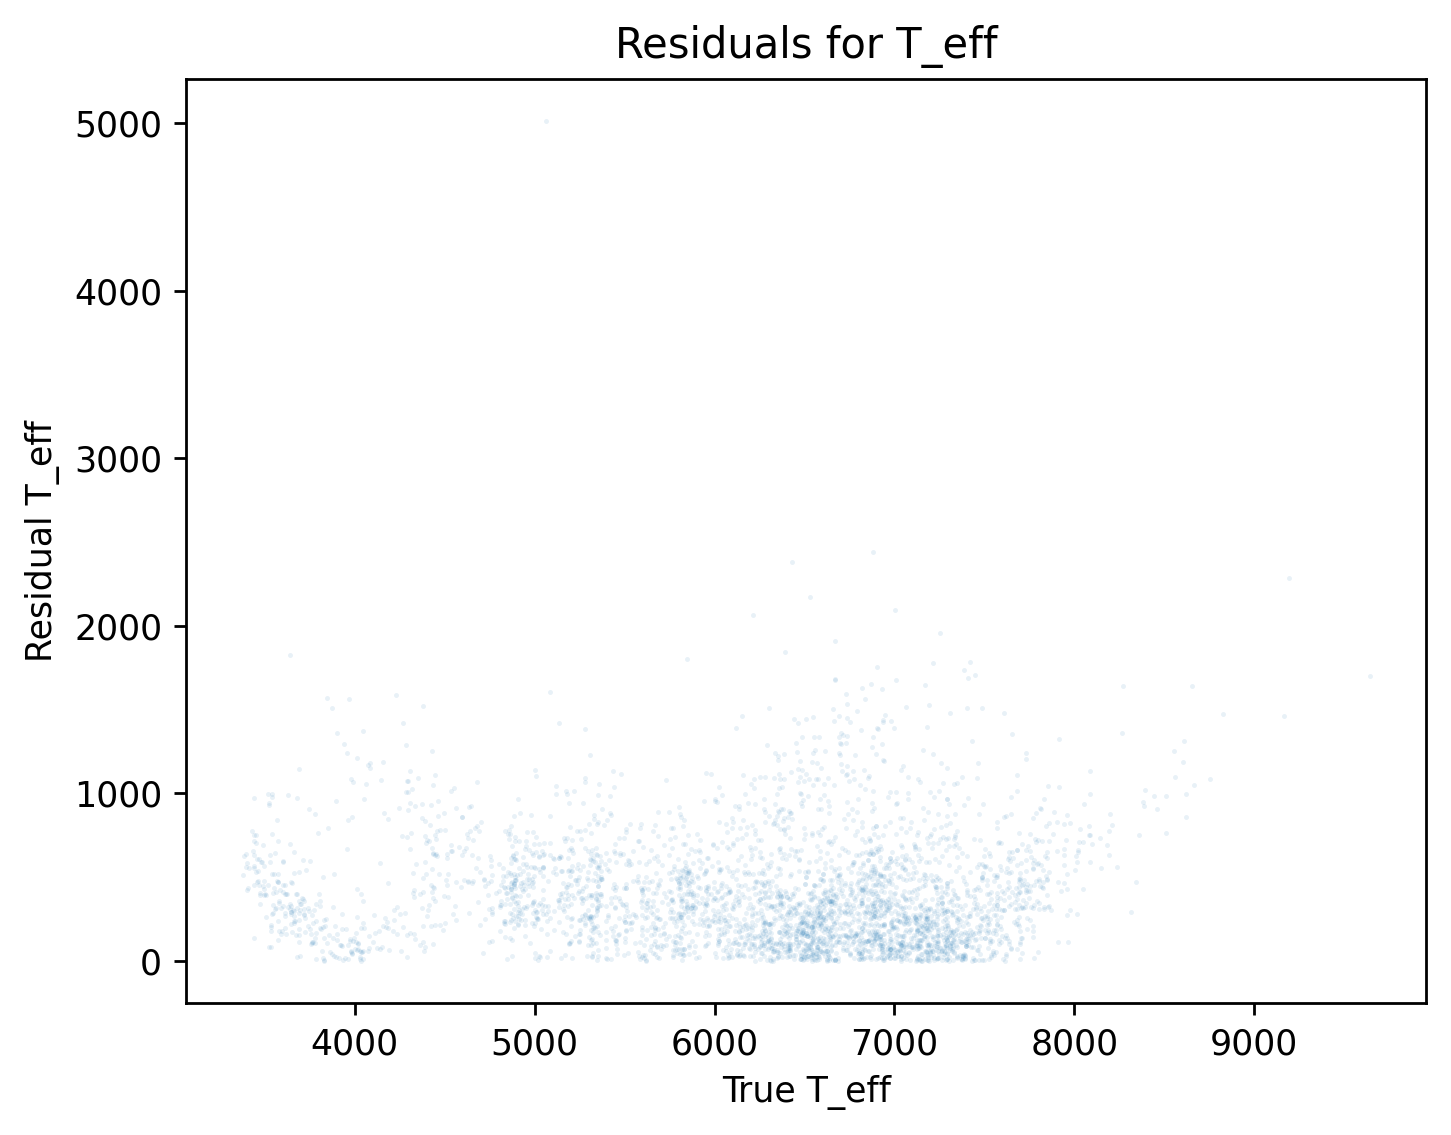

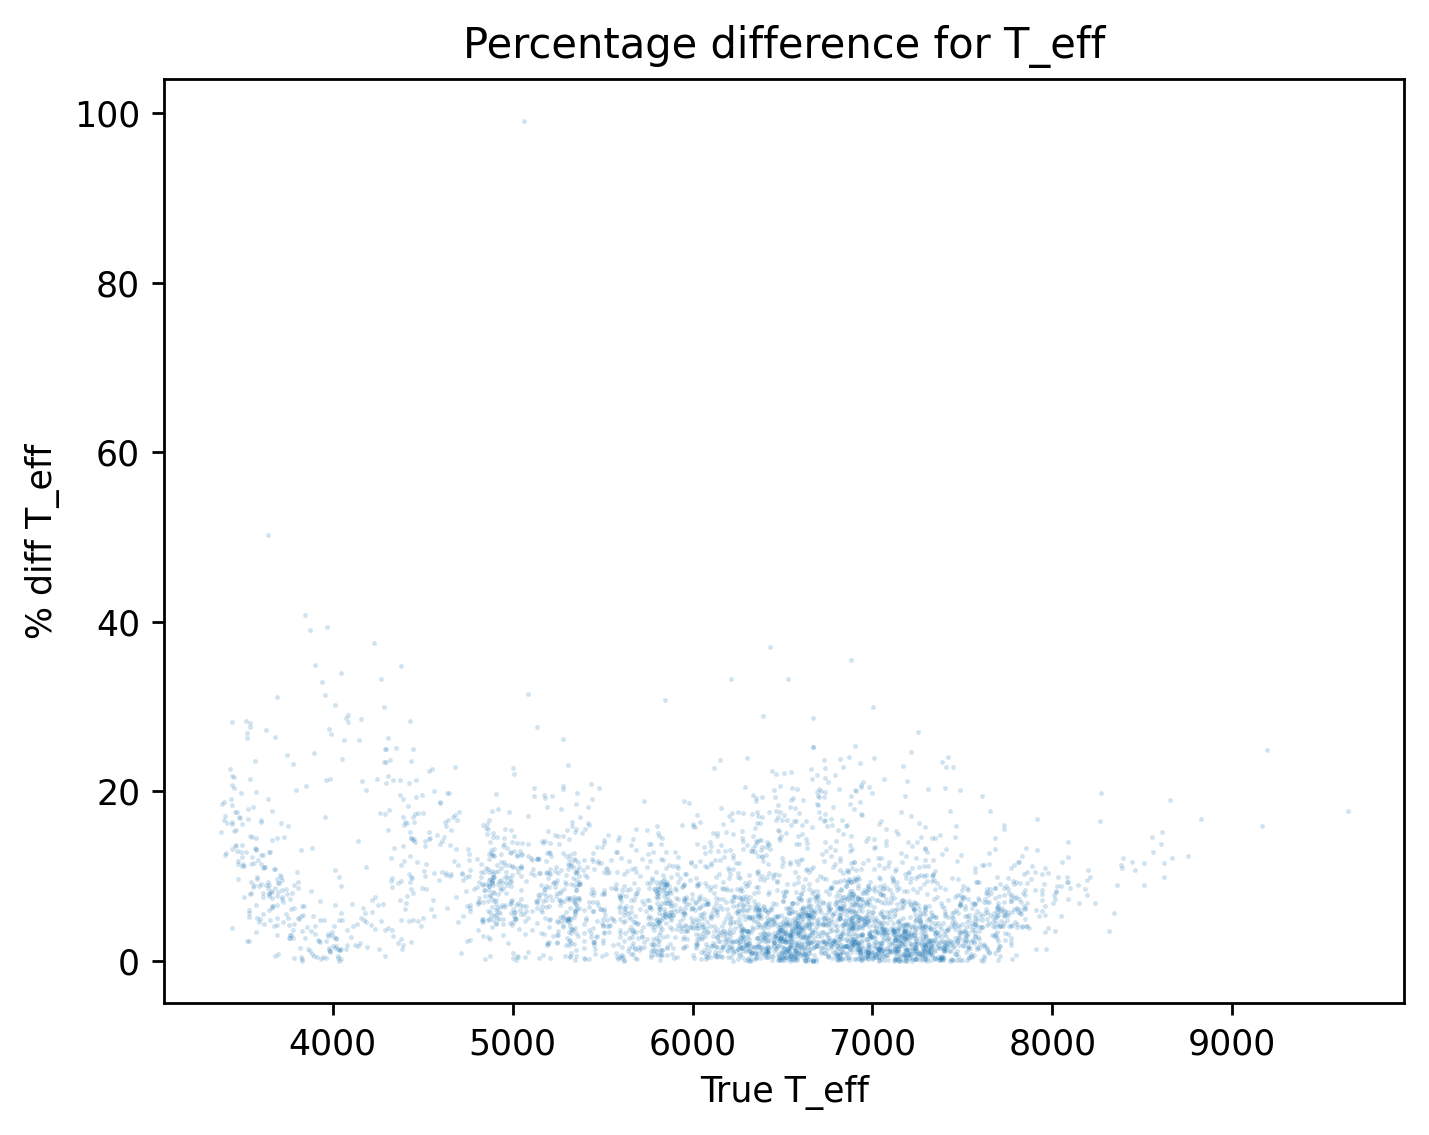

In [23]:
df = output_df # Make another alias to not break the code

param = 'T_eff'

true = 'True_'+param
mean= 'mean_'+param
median = 'median_'+param

sel = df[[true, mean, median]][df[true]>0].copy()

# Median
# Plot true vs real

plt.figure(dpi=250)
plt.scatter(sel[true], sel[median], s=3, alpha=0.1, lw=0)
# plt.plot([sel[true].min(),sel[true].max()],[sel[median].min(),sel[median].max()], c='r')
plt.ylabel('Median predicted '+param )
plt.xlabel('True '+param)
plt.title('Prediction of median {} parameter'.format(param))
plt.show()

# Plot RSE
# rse = np.sqrt(np.power(sel[true]-sel[pred],2))
rse = np.abs(sel[true]-sel[median])
plt.figure(dpi=250)
plt.scatter(sel[true], rse, s=2, lw=0, alpha=0.1)
# plt.plot([0,160],[0,160], c='r')
plt.xlabel('True '+param )
plt.ylabel('Residual '+param)
plt.title('Residuals for {}'.format(param))
plt.show()

# Plot of % difference
perc_dif = 100*np.abs(sel[true]-sel[median])/sel[true]
sel = sel.assign(p_diff=perc_dif)

plt.figure(dpi=250)
plt.scatter(sel[true], perc_dif, s=2, lw=0, alpha=0.2)
# plt.plot([0,160],[0,160], c='r')
plt.xlabel('True '+param )
# plt.xscale('log')
plt.ylabel('% diff '+param)
plt.title('Percentage difference for {}'.format(param))
plt.show()
# break

In [27]:
n_bins =20
param_range = sel[true].max()-sel[true].min()
step = param_range/n_bins
bins = np.arange(sel[true].min(),sel[true].max(), step)

centers = []
datas = []
for i in range(1,bins.shape[0]):
    b1 = sel[true]>=bins[i-1]
    b2 = sel[true]<=bins[i]
    b = np.logical_and(b1,b2)
    sel_ = sel[b]
    
    mid_bin = round(bins[i-1]+(bins[i]-bins[i-1])/2, 2)
    centers.append(str(mid_bin))
    datas.append(sel_['p_diff'])

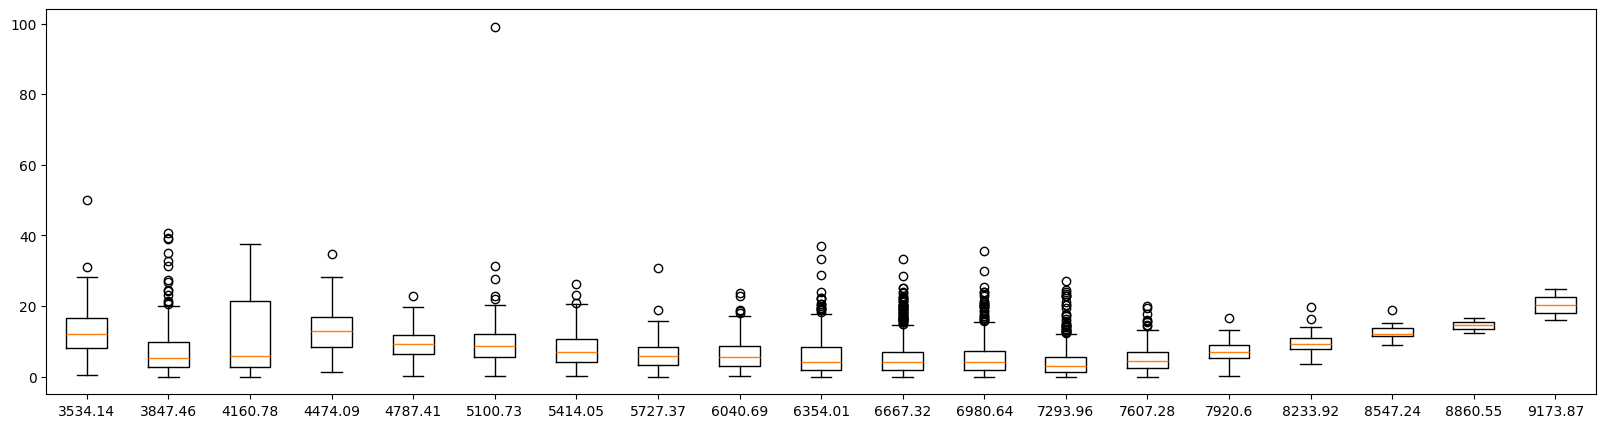

In [28]:
plt.figure(figsize=(20,5))
plt.boxplot(datas, labels=centers)
plt.show()

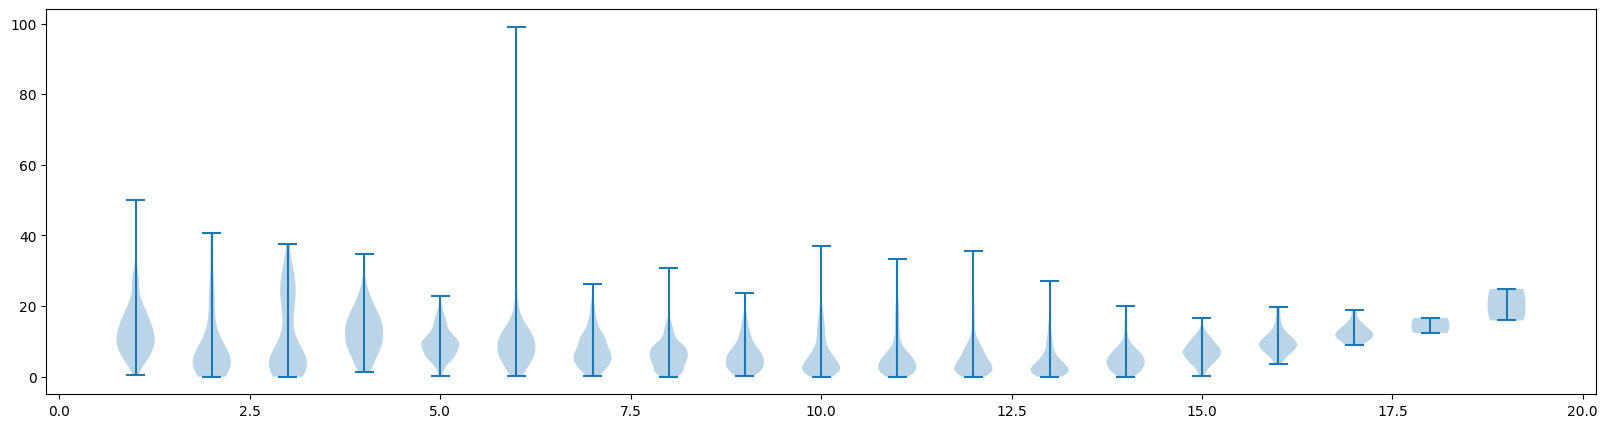

In [29]:
plt.figure(figsize=(20,5))
plt.violinplot(datas )
plt.show()